# KGAT: Knowledge Graph Attention Network
Danielle Lambion<br>
TCSS 556: Spring 2021<br>
Professor Ankur Teredesai<br><br>

This notebook shows reproduction of results from the KGAT paper by authors Xiang Wang, Xiangnan He, Yixin Cao, Meng Liu, and Tat-Seng Chua<br>

The machine showing this reproduction is running Python 3.6.8 with numpy 1.19.5, scipy 1.4.1, sklearn 0.22.1, and Tensorflow 2.4.1 with version 1 compatability imported in some files.<br><br>
Tensorflow is GPU enabled running on an NVIDIA GeForce RTX 2060 Super and CPU is an Intel i5-9600k @ 3.70GHz 6 cores on a Windows 10 machine.<br>

- Tensorflow version 1 compatability was imported in Main.py
- In KGAT.py, I replaced the xavier initializer with glorot uniform to account for versioning changes in Tensorflow 2.

<br>

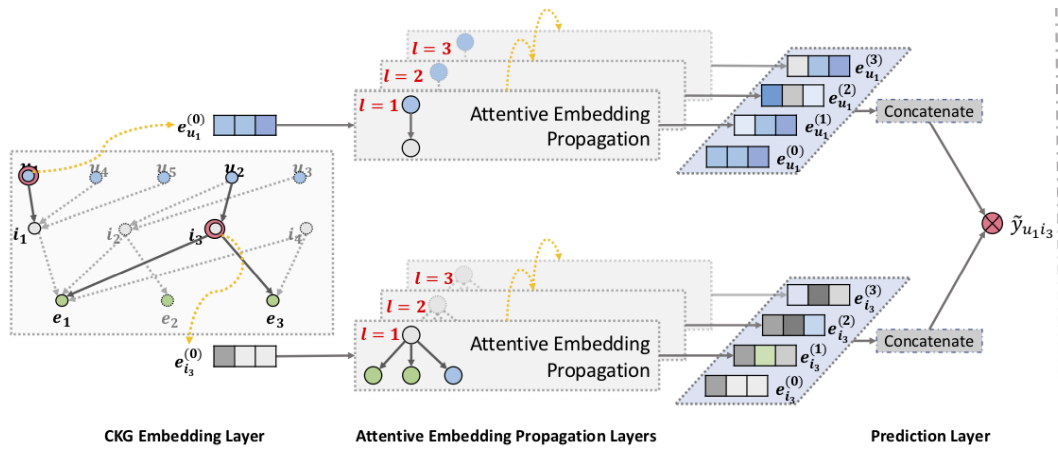

<br><br><br><br>
# CKG Embedding Layer

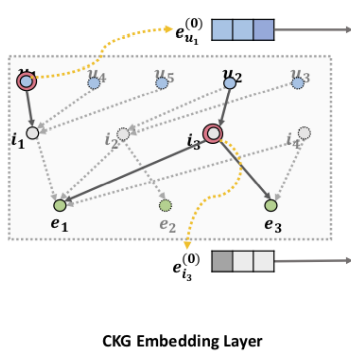

In [1]:
    def _build_inputs(self):
        # placeholder definition
        self.users = tf.placeholder(tf.int32, shape=(None,))
        self.pos_items = tf.placeholder(tf.int32, shape=(None,))
        self.neg_items = tf.placeholder(tf.int32, shape=(None,))

        # for knowledge graph modeling (TransD)
        self.A_values = tf.placeholder(tf.float32, shape=[len(self.all_v_list)], name='A_values')

        self.h = tf.placeholder(tf.int32, shape=[None], name='h')
        self.r = tf.placeholder(tf.int32, shape=[None], name='r')
        self.pos_t = tf.placeholder(tf.int32, shape=[None], name='pos_t')
        self.neg_t = tf.placeholder(tf.int32, shape=[None], name='neg_t')

        # dropout: node dropout (adopted on the ego-networks);
        # message dropout (adopted on the convolution operations).
        self.node_dropout = tf.placeholder(tf.float32, shape=[None])
        self.mess_dropout = tf.placeholder(tf.float32, shape=[None])

In [ ]:
    def _build_weights(self):
        all_weights = dict()
        initializer = tf.initializers.glorot_uniform()
        
        if self.pretrain_data is None:
            all_weights['user_embed'] = tf.Variable(initializer([self.n_users, self.emb_dim]), name='user_embed')
            all_weights['entity_embed'] = tf.Variable(initializer([self.n_entities, self.emb_dim]), name='entity_embed')
            print('using xavier initialization')
        else:
            all_weights['user_embed'] = tf.Variable(initial_value=self.pretrain_data['user_embed'], trainable=True,
                                                    name='user_embed', dtype=tf.float32)

            item_embed = self.pretrain_data['item_embed']
            other_embed = initializer([self.n_entities - self.n_items, self.emb_dim])

            all_weights['entity_embed'] = tf.Variable(initial_value=tf.concat([item_embed, other_embed], 0),
                                                      trainable=True, name='entity_embed', dtype=tf.float32)
            print('using pretrained initialization')

        all_weights['relation_embed'] = tf.Variable(initializer([self.n_relations, self.kge_dim]),
                                                    name='relation_embed')
        all_weights['trans_W'] = tf.Variable(initializer([self.n_relations, self.emb_dim, self.kge_dim]))

        self.weight_size_list = [self.emb_dim] + self.weight_size


        for k in range(self.n_layers):
            all_weights['W_gc_%d' %k] = tf.Variable(
                initializer([self.weight_size_list[k], self.weight_size_list[k+1]]), name='W_gc_%d' % k)
            all_weights['b_gc_%d' %k] = tf.Variable(
                initializer([1, self.weight_size_list[k+1]]), name='b_gc_%d' % k)

            all_weights['W_bi_%d' % k] = tf.Variable(
                initializer([self.weight_size_list[k], self.weight_size_list[k + 1]]), name='W_bi_%d' % k)
            all_weights['b_bi_%d' % k] = tf.Variable(
                initializer([1, self.weight_size_list[k + 1]]), name='b_bi_%d' % k)

            all_weights['W_mlp_%d' % k] = tf.Variable(
                initializer([2 * self.weight_size_list[k], self.weight_size_list[k+1]]), name='W_mlp_%d' % k)
            all_weights['b_mlp_%d' % k] = tf.Variable(
                initializer([1, self.weight_size_list[k+1]]), name='b_mlp_%d' % k)

        return all_weights

# Attentive Embedding Propagation Layers


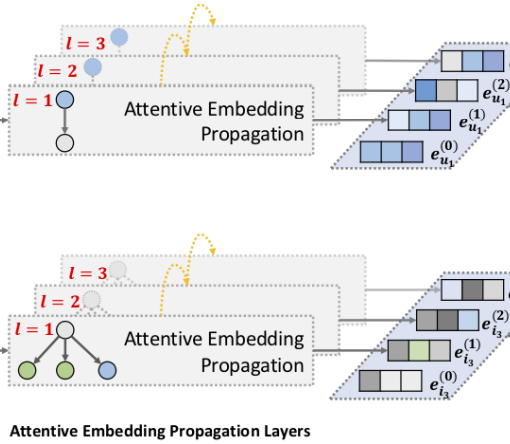
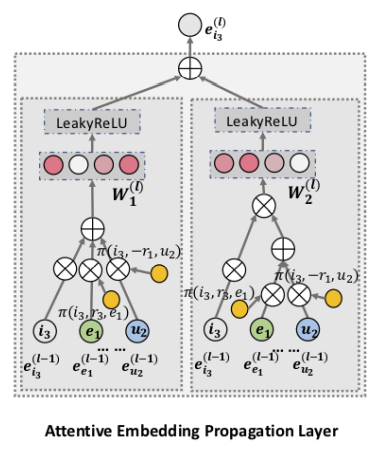
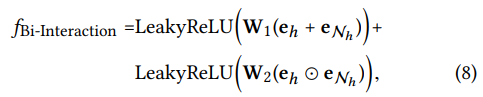

#### This function creates the bi-interaction embeddings for users, items, and knowledge graph entities

In [ ]:
    def _create_bi_interaction_embed(self):
        A = self.A_in
        # Generate a set of adjacency sub-matrix.
        A_fold_hat = self._split_A_hat(A)

        ego_embeddings = tf.concat([self.weights['user_embed'], self.weights['entity_embed']], axis=0)
        all_embeddings = [ego_embeddings]

        for k in range(0, self.n_layers):
            # A_hat_drop = tf.nn.dropout(A_hat, 1 - self.node_dropout[k], [self.n_users + self.n_items, 1])
            temp_embed = []
            for f in range(self.n_fold):
                temp_embed.append(tf.sparse_tensor_dense_matmul(A_fold_hat[f], ego_embeddings))

            # sum messages of neighbors.
            side_embeddings = tf.concat(temp_embed, 0)

            add_embeddings = ego_embeddings + side_embeddings

            # transformed sum messages of neighbors.
            sum_embeddings = tf.nn.leaky_relu(
                tf.matmul(add_embeddings, self.weights['W_gc_%d' % k]) + self.weights['b_gc_%d' % k])


            # bi messages of neighbors.
            bi_embeddings = tf.multiply(ego_embeddings, side_embeddings)
            # transformed bi messages of neighbors.
            bi_embeddings = tf.nn.leaky_relu(
                tf.matmul(bi_embeddings, self.weights['W_bi_%d' % k]) + self.weights['b_bi_%d' % k])

            ego_embeddings = bi_embeddings + sum_embeddings
            # message dropout.
            ego_embeddings = tf.nn.dropout(ego_embeddings, 1 - self.mess_dropout[k])

            # normalize the distribution of embeddings.
            norm_embeddings = tf.math.l2_normalize(ego_embeddings, axis=1)

            all_embeddings += [norm_embeddings]

        all_embeddings = tf.concat(all_embeddings, 1)

        ua_embeddings, ea_embeddings = tf.split(all_embeddings, [self.n_users, self.n_entities], 0)
        return ua_embeddings, ea_embeddings

# Prediction Layer

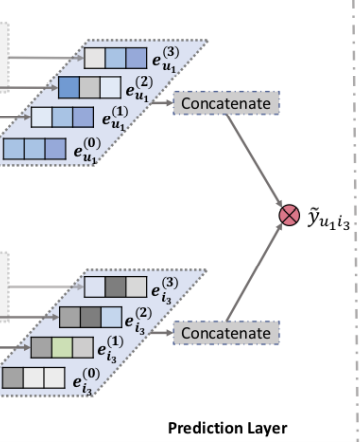

In [ ]:
self.u_e = tf.nn.embedding_lookup(self.ua_embeddings, self.users)
self.pos_i_e = tf.nn.embedding_lookup(self.ea_embeddings, self.pos_items)

self.batch_predictions = tf.matmul(self.u_e, self.pos_i_e, transpose_a=False, transpose_b=True)